# Process Data
In this notebook, we take the protein data from each file in protein-data to create a dataframe that contains the entry id, entity id, sequence, name, function, and binding site for each protein. This information is uploaded to the MongoDB database.

In [19]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt

import re

## Generate a dataframe with the protein data

In [2]:
def generate_protein_df(data_folder):
    """
    Generate a dataframe of protein data from the protein data folder.
    The dataframe will contain sequence(str), entry_id(str), entity_id(str), function(str), binding_sites(list) columns.
    Input: data_folder - the folder containing all the protein data
    Output: protein_df - a dataframe of binding site data
    """
    protein_df = []
    for file in os.listdir(data_folder):
        with open(os.path.join(data_folder, file), "r") as f:
            protein_data = json.load(f)
            entry_id = protein_data["entry_id"]
            for entity_id, data in protein_data["uniprot_annotations"].items():
                if not data:
                    continue
                sequence = data["rcsb_uniprot_protein"]["sequence"]
                name = data["rcsb_uniprot_protein"].get("name", "")
                if name:
                    name_val = name["value"]
                else:
                    name_val = ""
                function = data["rcsb_uniprot_protein"].get("function", "")
                if function:
                    function_details = function["details"]
                else:
                    function_details = ""
                binding_sites = []
                for feature in data["rcsb_uniprot_feature"]:
                    if feature["type"] == "BINDING_SITE":
                        for site in feature["feature_positions"]:
                            binding_site = site["beg_seq_id"]
                            binding_sites.append(binding_site)
                
                protein_df.append([entry_id, entity_id, sequence, name_val, function_details, binding_sites])

    protein_df = pd.DataFrame(protein_df, columns=["entry_id", "entity_id", "sequence", "name", "function", "binding_sites"])

    return protein_df

In [3]:
data_folder = "protein_data"
protein_df = generate_protein_df(data_folder)

In [5]:
# convert protein_df to a csv file and save to 'processed_data' folder
protein_df.to_csv("data_output/protein_data.csv", index=False)

print(protein_df.shape)
protein_df.head()

(114890, 6)


,entry_id,entity_id,sequence,name,function,binding_sites
0,3EO1,2,ASTKGPSVFPLAPCSRSTSESTAALGCLVKDYFPEPVTVSWNSGAL...,Immunoglobulin heavy constant gamma 4,Constant region of immunoglobulin heavy chains...,[]
1,3EO1,3,MKMHLQRALVVLALLNFATVSLSLSTCTTLDFGHIKKKRVEAIRGQ...,Transforming growth factor beta-3 proprotein,Transforming growth factor beta-3 proprotein: ...,[]
2,1B7Q,1,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,Lysozyme C,Lysozymes have primarily a bacteriolytic funct...,[]
3,8CUA,1,MGKPARKGCEWKRFLKNNWVLLSTVAAVVLGITTGVLVREHSNLST...,Excitatory amino acid transporter 3,"Sodium-dependent, high-affinity amino acid tra...","[411, 98, 451, 362, 455, 102, 448, 408, 370, 4..."
4,4BC4,1,MAEHAPRRCCLGWDFSTQQVKVVAVDAELNVFYEESVHFDRDLPEF...,Xylulose kinase,Phosphorylates D-xylulose to produce D-xylulos...,"[441, 170, 280, 281, 445, 99, 355]"


## Preprocess Data

In [20]:
def load_and_process_data(dataset_path):

    # Load the dataset
    df = pd.read_csv(dataset_path)

    # Cast 'function' values as str
    df['function'] = df['function'].astype(str)

    # Cast 'function' values as str
    df['name'] = df['name'].astype(str)

    # Define the function to remove citations inside the main function
    def remove_citations(text):
        text = str(text)
        # Adjusted pattern to match sequences of citations
        pattern = r"\(\w+:\d+(?:,\s*\w+:\d+)*\)"
        cleaned_text = re.sub(pattern, "", text)
        return cleaned_text
    
    # Filter sequences with length <= 1000
    df = df[df['sequence'].apply(len) <= 1000]

    # Remove sequences where function > 128
    df = df[df['function'].apply(lambda x: len(x.split()) <= 128)]

    # Remove sequences where name == '' or function = ''
    df = df[(df['name'] != '') & (df['function'] != '')]
    
    # Apply the remove_citations function to the 'function' column
    df['function'] = df['function'].apply(remove_citations)
    
    return df

# Specify the path to your dataset
dataset_path = "data_output/protein_data.csv"

# Load and process the data
processed_protein_data = load_and_process_data(dataset_path)

# Save df to "data_output" folder
processed_protein_data.to_csv("data_output/processed_protein_data.csv", index=False)

## Visualize Data

### Binding Sites

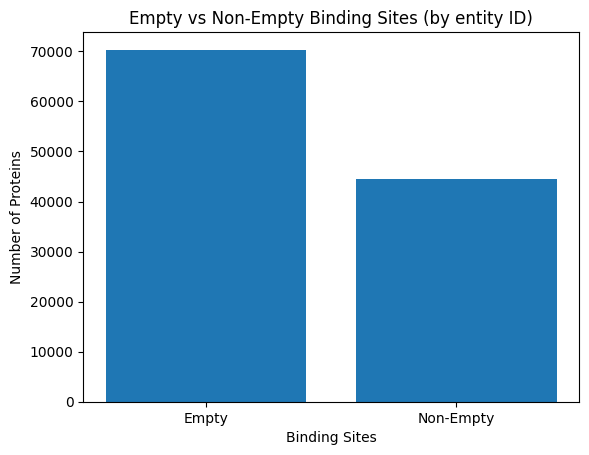

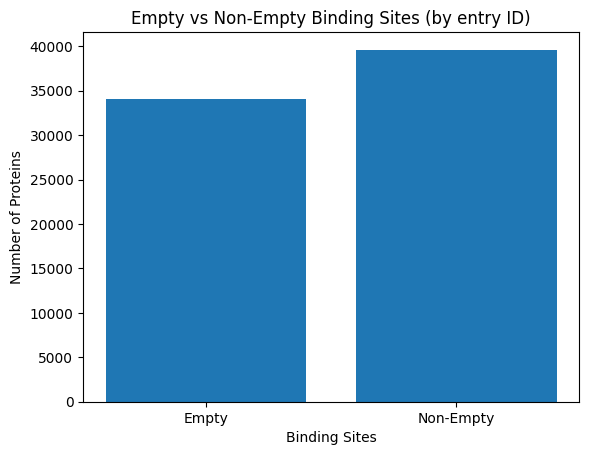

In [6]:
# graph total number of rows with empty "binding_sites" vs non-empty "binding_sites" column
empty_binding_sites = protein_df[protein_df["binding_sites"].apply(len) == 0]
non_empty_binding_sites = protein_df[protein_df["binding_sites"].apply(len) > 0]

plt.bar(["Empty", "Non-Empty"], [len(empty_binding_sites), len(non_empty_binding_sites)])
plt.title("Empty vs Non-Empty Binding Sites (by entity ID)")
plt.xlabel("Binding Sites")
plt.ylabel("Number of Proteins")
plt.show()

# graph the total number of entry_ids with empty "binding_sites" vs non-empty "binding_sites" column
empty_binding_sites = empty_binding_sites["entry_id"].nunique()
non_empty_binding_sites = non_empty_binding_sites["entry_id"].nunique()

plt.bar(["Empty", "Non-Empty"], [empty_binding_sites, non_empty_binding_sites])
plt.title("Empty vs Non-Empty Binding Sites (by entry ID)")
plt.xlabel("Binding Sites")
plt.ylabel("Number of Proteins")
plt.show()

### Function

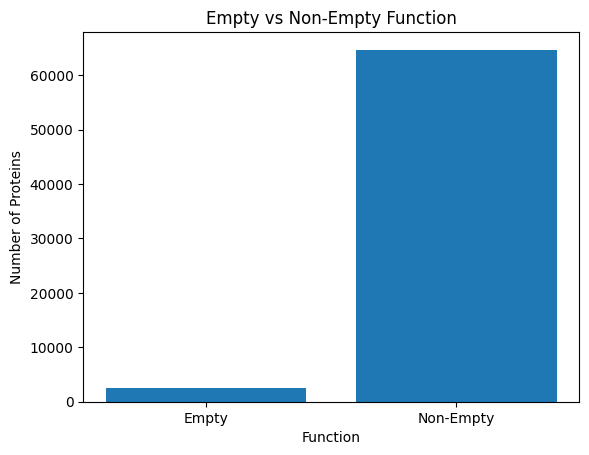

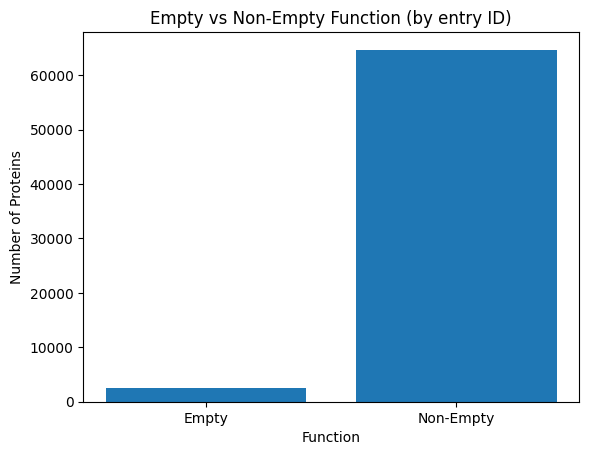

In [9]:
# graph the total number of proteins with empty "function_details" vs non-empty "function_details" column

empty_function_details = protein_df[protein_df["function"] == ""]
non_empty_function_details = protein_df[protein_df["function"] != ""]
empty_function_details = empty_function_details["entry_id"].nunique()
non_empty_function_details = non_empty_function_details["entry_id"].nunique()

plt.bar(["Empty", "Non-Empty"], [empty_function_details, non_empty_function_details])
plt.title("Empty vs Non-Empty Function")
plt.xlabel("Function")
plt.ylabel("Number of Proteins")
plt.show()

# graph the total number of entry_ids with empty "function_details" vs non-empty "function_details" column
empty_function_details = protein_df[protein_df["function"] == ""]
non_empty_function_details = protein_df[protein_df["function"] != ""]
empty_function_details = empty_function_details["entry_id"].nunique()
non_empty_function_details = non_empty_function_details["entry_id"].nunique()

plt.bar(["Empty", "Non-Empty"], [empty_function_details, non_empty_function_details])
plt.title("Empty vs Non-Empty Function (by entry ID)")
plt.xlabel("Function")
plt.ylabel("Number of Proteins")
plt.show()

## Name

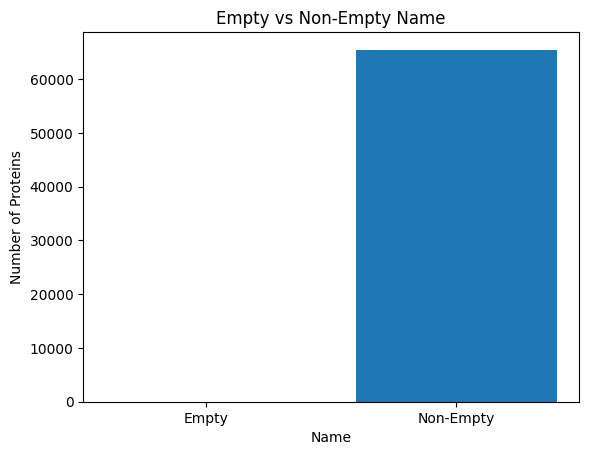

In [11]:
# graph the total number of proteins with empty "name" vs non-empty "name" column
empty_name = protein_df[protein_df["name"] == ""]
non_empty_name = protein_df[protein_df["name"] != ""]
empty_name = empty_name["entry_id"].nunique()
non_empty_name = non_empty_name["entry_id"].nunique()

plt.bar(["Empty", "Non-Empty"], [empty_name, non_empty_name])
plt.title("Empty vs Non-Empty Name")
plt.xlabel("Name")
plt.ylabel("Number of Proteins")
plt.show()

In [15]:
# return the number of unique 'names'
unique_names = protein_df["name"].nunique()
print("Number of unique names:", unique_names)

# return the number of unique 'functions'
unique_functions = protein_df["function"].nunique()
print("Number of unique functions:", unique_functions)

Number of unique names: 9780
Number of unique functions: 8926


In [10]:
import pandas as pd
protein_df = pd.read_csv("data_output/protein_data.csv")

# group protein sequences by length in groups of 100 (e.g. 0-100, 101-200, 201-300, etc.) and store them in a list
protein_df["sequence_length"] = protein_df["sequence"].apply(len)
protein_df["sequence_length_group"] = protein_df["sequence_length"] // 1000 * 1000
protein_df["sequence_length_group"] = protein_df["sequence_length_group"].astype(str) + "-" + (protein_df["sequence_length_group"] + 1000).astype(str)
sequence_length_groups = protein_df.groupby("sequence_length_group").size().reset_index(name="count")

# print the list of protein sequences by length in groups of 1000
print(sequence_length_groups)


   sequence_length_group  count
0                 0-1000  98732
1              1000-2000  13107
2            14000-15000      1
3              2000-3000   2130
4              3000-4000    472
5            34000-35000     65
6              4000-5000    221
7              5000-6000     76
8              6000-7000      6
9              7000-8000     77
10             8000-9000      3


In [13]:
# get the first 3347 rows of protein_df
protein_df_first3347 = protein_df.head(3347)

# print the max length of all protein sequences of the first 3347 rows in protein_df
max_length = protein_df_first3347["sequence"].apply(len).max()
print(max_length)

7968


In [17]:
# get sequences that have length <= 1000 (filter protein_df)
protein_df_1000 = protein_df[protein_df["sequence_length"] <= 1000]
print(len(protein_df_1000))

# find number of unique 'function'
unique_functions = protein_df_1000["function"].nunique()
print(unique_functions)

# find number of unique 'name'
unique_names = protein_df_1000["name"].nunique()
print(unique_names)

98734
7622
8470


In [18]:
protein_df_1000.head(30)

,entry_id,entity_id,sequence,name,function,binding_sites,sequence_length,sequence_length_group
0,3EO1,2,ASTKGPSVFPLAPCSRSTSESTAALGCLVKDYFPEPVTVSWNSGAL...,Immunoglobulin heavy constant gamma 4,Constant region of immunoglobulin heavy chains...,[],396,0-1000
1,3EO1,3,MKMHLQRALVVLALLNFATVSLSLSTCTTLDFGHIKKKRVEAIRGQ...,Transforming growth factor beta-3 proprotein,Transforming growth factor beta-3 proprotein: ...,[],412,0-1000
2,1B7Q,1,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,Lysozyme C,Lysozymes have primarily a bacteriolytic funct...,[],148,0-1000
3,8CUA,1,MGKPARKGCEWKRFLKNNWVLLSTVAAVVLGITTGVLVREHSNLST...,Excitatory amino acid transporter 3,"Sodium-dependent, high-affinity amino acid tra...","[411, 98, 451, 362, 455, 102, 448, 408, 370, 4...",524,0-1000
4,4BC4,1,MAEHAPRRCCLGWDFSTQQVKVVAVDAELNVFYEESVHFDRDLPEF...,Xylulose kinase,Phosphorylates D-xylulose to produce D-xylulos...,"[441, 170, 280, 281, 445, 99, 355]",536,0-1000
5,5QU2,1,MAEEVVVVAKFDYVAQQEQELDIKKNERLWLLDDSKSWWRVRNSMN...,SH2/SH3 adapter protein NCK1,Adapter protein which associates with tyrosine...,[],377,0-1000
6,5QU2,2,MQSGTHWRVLGLCLLSVGVWGQDGNEEMGGITQTPYKVSISGTTVI...,T-cell surface glycoprotein CD3 epsilon chain,Part of the TCR-CD3 complex present on T-lymph...,[],207,0-1000
7,6PPL,1,MKGSRIELGDVTPHNIKQLKRLNQVIFPVSYNDKFYKDVLEVGELA...,N-alpha-acetyltransferase 50,N-alpha-acetyltransferase that acetylates the ...,"[75, 77, 31, 117, 138]",169,0-1000
8,6PPL,2,MPAVSLPPKENALFKRILRCYEHKQYRNGLKFCKQILSNPKFAEHG...,"N-alpha-acetyltransferase 15, NatA auxiliary s...",Auxillary subunit of N-terminal acetyltransfer...,[],866,0-1000
9,6PPL,3,MNIRNARPEDLMNMQHCNLLCLPENYQMKYYFYHGLSWPQLSYIAE...,N-alpha-acetyltransferase 10,Catalytic subunit of N-terminal acetyltransfer...,[],235,0-1000
